# 🚜 Predicting the Sale Price of Bulldozers using Machine Learning

In this notebook, we're going to go through an example machine learning project with the goal of predicting the sale price of bulldozers.

## 1. Problem defition

> How well can we predict the future sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers have been sold for?

## 2. Data

The data is downloaded from the Kaggle Bluebook for Bulldozers competition: https://www.kaggle.com/c/bluebook-for-bulldozers/data

There are 3 main datasets:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project check: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

**Note:** The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimises RMSLE.

## 4. Features

Kaggle provides a data dictionary detailing all of the features of the dataset. You can view this data dictionary on Google Sheets: https://docs.google.com/spreadsheets/d/18ly-bLR8sbDJLITkWG7ozKm8l3RyieQ2Fpgix-beSYI/edit?usp=sharing

In [414]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,mean_squared_log_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer


In [447]:
# Import training and validation sets
df = pd.read_csv(r"C:\Users\ainao\Downloads\Projects\Bulldozer Project\data\bulldozer\TrainAndValid.csv",
                 low_memory=False)

In [448]:
# Import the test data
df_test = pd.read_csv(r"C:\Users\ainao\Downloads\Projects\Bulldozer Project\data\bulldozer\Test.csv",
                      low_memory=False,
                      parse_dates=["saledate"])

df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [449]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [450]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

In [451]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

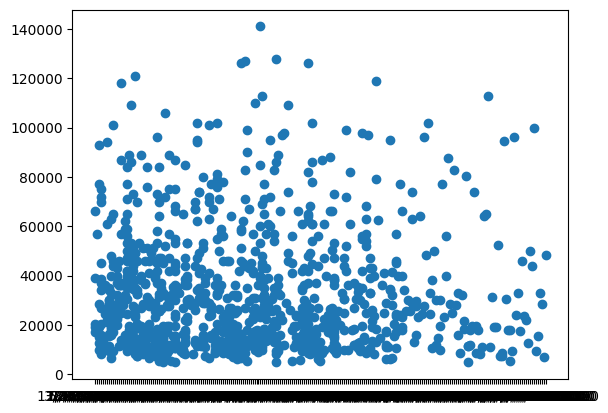

In [452]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])

In [453]:
df.saledate[:1000]

0      11/16/2006 0:00
1       3/26/2004 0:00
2       2/26/2004 0:00
3       5/19/2011 0:00
4       7/23/2009 0:00
            ...       
995     7/16/2009 0:00
996     6/14/2007 0:00
997     9/22/2005 0:00
998     7/28/2005 0:00
999     6/16/2011 0:00
Name: saledate, Length: 1000, dtype: object

In [454]:
df.saledate.dtype

dtype('O')

<Axes: ylabel='Frequency'>

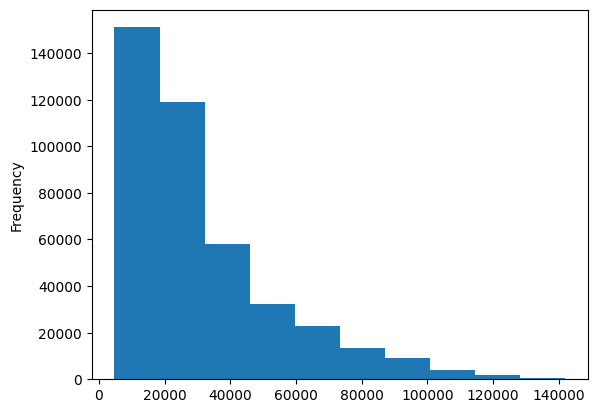

In [455]:
df.SalePrice.plot.hist()

### Parsing dates

When we work with time series data, we want to enrich the time & date component as much as possible.

We can do that by telling pandas which of our columns has dates in it using the `parse_dates` parameter.

In [456]:
# Import data again but this time parse dates
df = pd.read_csv(r"C:\Users\ainao\Downloads\Projects\Bulldozer Project\data\bulldozer\TrainAndValid.csv",
                 low_memory=False,
                 parse_dates=["saledate"])

In [457]:
# Import the test data
df_test = pd.read_csv(r"C:\Users\ainao\Downloads\Projects\Bulldozer Project\data\bulldozer\Test.csv",
                      low_memory=False,
                      parse_dates=["saledate"])

df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [458]:
df.saledate[:1000]

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

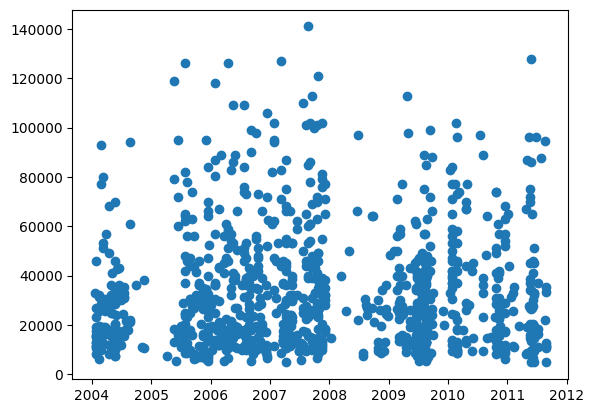

In [459]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])

In [460]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [461]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [462]:
df.saledate.head(20)

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
5    2008-12-18
6    2004-08-26
7    2005-11-17
8    2009-08-27
9    2007-08-09
10   2008-08-21
11   2006-08-24
12   2005-10-20
13   2006-01-26
14   2006-01-03
15   2006-11-16
16   2007-06-14
17   2010-01-28
18   2006-03-09
19   2005-11-17
Name: saledate, dtype: datetime64[ns]

### Sort DataFrame by saledate

When working with time series data, it's a good idea to sort it by date.

In [463]:
# Sort DataFrame in date order
df.sort_values(by=["saledate"], inplace=True, ascending=True)
df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Make a copy of the original DataFrame

We make a copy of the original dataframe so when we manipulate the copy, we've still got our original data.

In [464]:
# Make a copy of the original DataFrame to perform edits on
df_tmp = df.copy()

In [465]:
# Check the values of different columns
df_tmp.state.value_counts()

state
Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Iowa               1336
Montana            1336
Oklahoma           1326
Nebraska            866
West Virgi

In [466]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN


In [467]:
len(df_tmp)

412698

In [468]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

In [469]:
df_tmp["UsageBand"].dtype

dtype('O')

In [470]:
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

### Convert string to categories

One way we can turn all of our data into numbers is by converting them into pandas catgories.



In [471]:
df_tmp.dtypes

SalesID                              int64
SalePrice                          float64
MachineID                            int64
ModelID                              int64
datasource                           int64
auctioneerID                       float64
YearMade                             int64
MachineHoursCurrentMeter           float64
UsageBand                           object
saledate                    datetime64[ns]
fiModelDesc                         object
fiBaseModel                         object
fiSecondaryDesc                     object
fiModelSeries                       object
fiModelDescriptor                   object
ProductSize                         object
fiProductClassDesc                  object
state                               object
ProductGroup                        object
ProductGroupDesc                    object
Drive_System                        object
Enclosure                           object
Forks                               object
Pad_Type   

In [472]:
def extract_date_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["saleYear"] = df["saledate"].dt.year
    df["saleMonth"] = df["saledate"].dt.month
    df["saleDay"] = df["saledate"].dt.day
    df["saleDayOfWeek"] = df["saledate"].dt.dayofweek
    df["saleDayOfYear"] = df["saledate"].dt.dayofyear
    return df

In [473]:
df_tmp = extract_date_features(df_tmp)
df_test = extract_date_features(df_test)

In [474]:
df_tmp

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,1,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410879,6302984,16000.0,1915521,5266,149,99.0,2001,NaN,NaN,2012-04-28,...,None or Unspecified,PAT,None or Unspecified,NaN,NaN,2012,4,28,5,119
412476,6324811,6000.0,1919104,19330,149,99.0,2004,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,2012,4,28,5,119
411927,6313029,16000.0,1918416,17244,149,99.0,2004,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,2012,4,28,5,119
407124,6266251,55000.0,509560,3357,149,99.0,1993,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,2012,4,28,5,119


In [475]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder

def build_preprocessor(df: pd.DataFrame):
    # Drop target if it's present
    df = df.drop(columns=["SalePrice"], errors="ignore")

    # Identify numerical and categorical columns
    num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
    cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()

    # Define transformers
    num_transformer = SimpleImputer(strategy="median")
    cat_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
    ])

    # Build column transformer
    preprocessor = ColumnTransformer([
        ("num", num_transformer, num_cols),
        ("cat", cat_transformer, cat_cols)
    ])

    return preprocessor


### Splitting data into train/validation sets

In [476]:
# Split data into training and validation
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

len(df_val), len(df_train)

(11573, 401125)

In [477]:
# Split data into X & y
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train.SalePrice
X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val.SalePrice

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, df_test.shape

((401125, 57), (401125,), (11573, 57), (11573,), (12457, 57))

In [478]:
# Step 2: Build and fit preprocessor
preprocessor = build_preprocessor(X_train)
X_train_processed = preprocessor.fit_transform(X_train)
X_valid_processed = preprocessor.transform(X_valid)
X_test_processed = preprocessor.transform(df_test)

In [486]:
X_train_processed.shape, y_train.shape,X_valid_processed.shape,y_valid.shape, X_test_processed.shape

((401125, 51), (401125,), (11573, 51), (11573,), (12457, 51))

### Building an evaluation function

In [487]:

def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    r2_square = r2_score(true, predicted)
    
    # Handle RMSLE safely
    true = np.maximum(0, true)
    predicted = np.maximum(0, predicted)
    try:
        msle = mean_squared_log_error(true, predicted)
        rmsle = np.sqrt(msle)
    except ValueError:
        rmsle = np.nan  # If data is inappropriate for RMSLE
    
    return mae, rmse, r2_square, rmsle


## Testing our model on a subset (to tune the hyperparameters)

In [488]:
def safe_rmsle(y_true, y_pred):
    """
    Computes RMSLE safely by ensuring predictions and targets are >= 0.
    """
    y_true = np.maximum(0, y_true)
    y_pred = np.maximum(0, y_pred)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [489]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    rmsle = safe_rmsle(true, predicted)
    r2_square = r2_score(true, predicted)
    return mae, rmse, rmsle, r2_square


In [501]:
import numpy as np
np.random.seed(42)

models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(random_state=42),
    "Ridge": Ridge(random_state=42),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest Regressor": RandomForestRegressor(random_state=42),
    "XGBRegressor": XGBRegressor(random_state=42), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False,random_state=42),
    "AdaBoost Regressor": AdaBoostRegressor(random_state=42)
}
model_list = []
Rmsle_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train_processed, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train_processed)
    y_valid_pred = model.predict(X_valid_processed)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse,model_train_rmsle, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_valid_mae , model_valid_rmse, model_valid_rmsle, model_valid_r2 = evaluate_model(y_valid, y_valid_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Root Mean Squared log Error: {:.4f}".format(model_train_rmsle))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_valid_rmse))
    print("- Root Mean Squared log Error: {:.4f}".format(model_valid_rmsle))
    print("- Mean Absolute Error: {:.4f}".format(model_valid_mae))
    print("- R2 Score: {:.4f}".format(model_valid_r2))
    Rmsle_list.append(model_valid_rmsle)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 17520.8954
- Root Mean Squared log Error: 0.9237
- Mean Absolute Error: 12614.1603
- R2 Score: 0.4216
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 19964.1237
- Root Mean Squared log Error: 1.0767
- Mean Absolute Error: 14548.4302
- R2 Score: 0.4197




c:\Users\ainao\Downloads\Projects\Bulldozer Project\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.238e+13, tolerance: 2.129e+10
  model = cd_fast.enet_coordinate_descent(


Lasso
Model performance for Training set
- Root Mean Squared Error: 17520.9614
- Root Mean Squared log Error: 0.9228
- Mean Absolute Error: 12614.2528
- R2 Score: 0.4215
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 19957.6327
- Root Mean Squared log Error: 1.0736
- Mean Absolute Error: 14545.2385
- R2 Score: 0.4201




c:\Users\ainao\Downloads\Projects\Bulldozer Project\venv\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=7.57894e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge
Model performance for Training set
- Root Mean Squared Error: 17520.8955
- Root Mean Squared log Error: 0.9237
- Mean Absolute Error: 12614.1649
- R2 Score: 0.4216
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 19963.9068
- Root Mean Squared log Error: 1.0767
- Mean Absolute Error: 14548.3208
- R2 Score: 0.4198


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 14305.3816
- Root Mean Squared log Error: 0.4213
- Mean Absolute Error: 9541.9562
- R2 Score: 0.6144
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 22367.5579
- Root Mean Squared log Error: 0.6242
- Mean Absolute Error: 15845.1588
- R2 Score: 0.2716


Decision Tree
Model performance for Training set
- Root Mean Squared Error: 0.0000
- Root Mean Squared log Error: 0.0000
- Mean Absolute Error: 0.0000
- R2 Score: 1.0000
----------------------------------
Model performance for Test set
- Root Mean Squ

## Results

In [502]:
pd.DataFrame(list(zip(model_list, Rmsle_list)), columns=['Model Name', 'Root Mean Squared log Error']).sort_values(by=["Root Mean Squared log Error"],ascending=True)

,Model Name,Root Mean Squared log Error
5,Random Forest Regressor,0.252020
7,CatBoosting Regressor,0.271045
6,XGBRegressor,0.277524
4,Decision Tree,0.349477
3,K-Neighbors Regressor,0.624201
8,AdaBoost Regressor,0.664986
1,Lasso,1.073600
2,Ridge,1.076655
0,Linear Regression,1.076664


In [515]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
rf_grid = {"n_estimators": np.arange(100, 2001, 100),
           "max_depth": [None, 10, 20, 30],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto","log2"]}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42),
                              param_distributions=rf_grid,
                              n_iter=2,
                              cv=5,
                              verbose=True)

# Fit the RandomizedSearchCV model
rs_model.fit(X_train_processed, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


c:\Users\ainao\Downloads\Projects\Bulldozer Project\venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ainao\Downloads\Projects\Bulldozer Project\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ainao\Downloads\Projects\Bulldozer Project\venv\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\ainao\Downloads\Projects\Bulldozer Project\venv\Lib\site-packages\sklearn\b

CPU times: total: 46min 21s
Wall time: 5min 15s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'max_features': [0.5, 1, 'sqrt', 'auto',
                                                         'log2'],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
       1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000])},
                   verbose=True)

In [516]:
# Find the best model hyperparameters
rs_model.best_params_

{'n_estimators': np.int64(100),
 'min_samples_split': np.int64(16),
 'min_samples_leaf': np.int64(9),
 'max_features': 0.5,
 'max_depth': None}

In [517]:
#Using best Params
model = RandomForestRegressor(n_estimators=100,
                                min_samples_split=16,
                                min_samples_leaf= 9,
                                max_features= 0.5,
                                max_depth=None,
                                random_state=42)


In [518]:
import numpy as np
np.random.seed(42)
RF_model = model
model.fit(X_train_processed, y_train)
y_pred = model.predict(X_valid_processed)

# Clip predictions to 0 to avoid negative values for RMSLE


score = (safe_rmsle(y_valid, y_pred))*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 24.50


## Plot y_pred and y_test

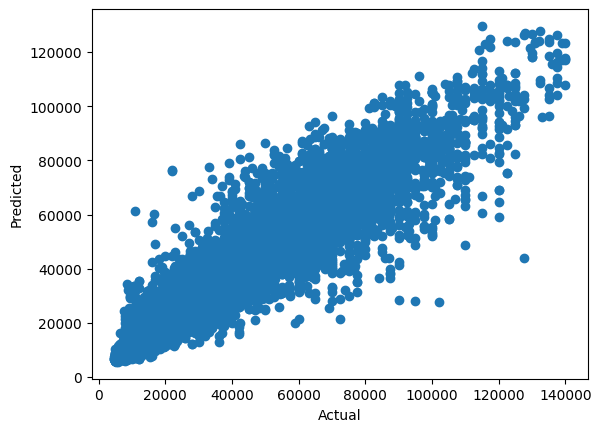

In [519]:
plt.scatter(y_valid,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

## Difference between Actual and Predicted Values

In [520]:
pred_df=pd.DataFrame({'Actual Value':y_valid,'Predicted Value':y_pred,'Difference':y_valid-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
405675,46173.2,40209.758330,5963.441670
401133,66000.0,63074.853020,2925.146980
406076,26800.0,19256.802693,7543.197307
409018,42100.0,37021.134230,5078.865770
409026,62100.0,53516.637262,8583.362738
...,...,...,...
410879,16000.0,18730.277157,-2730.277157
412476,6000.0,9327.549848,-3327.549848
411927,16000.0,21979.795694,-5979.795694
407124,55000.0,67589.134638,-12589.134638


In [522]:
pred_df.sort_index

<bound method DataFrame.sort_index of         Actual Value  Predicted Value    Difference
405675       46173.2     40209.758330   5963.441670
401133       66000.0     63074.853020   2925.146980
406076       26800.0     19256.802693   7543.197307
409018       42100.0     37021.134230   5078.865770
409026       62100.0     53516.637262   8583.362738
...              ...              ...           ...
410879       16000.0     18730.277157  -2730.277157
412476        6000.0      9327.549848  -3327.549848
411927       16000.0     21979.795694  -5979.795694
407124       55000.0     67589.134638 -12589.134638
409203       34000.0     37195.523278  -3195.523278

[11573 rows x 3 columns]>

In [521]:
#Save Model
import joblib
import os

# Assuming best_model is your trained model
MODEL_PATH = os.path.join("artifacts", "model.pkl")

joblib.dump(RF_model, MODEL_PATH)

print(f"✅ Model saved at: {MODEL_PATH}")


✅ Model saved at: artifacts\model.pkl
